<a name='T'>

<p style="padding: 20px;
          background-color: orange;
          font-family: computermodern;
          color: white;
          font-size: 200%;
          text-align: center;
          border-radius: 40px 20px;
          "><b>Deep Learning Project</b><br>
          </p>
<p style="font-family: computermodern;
          color: #000000;
          font-size: 175%;
          text-align: center;
          ">by AFYF Badreddine & CHABBAKI Ayman & AYAR Hanane<br>
            Written on the 28th of May 2025<br>
             </p>

![Cover Picture](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F17037041%2F702b7e593873b76b918fbfbc06bb8b16%2Fant.png?generation=1743933769719400&alt=media)

In [4]:
!git clone https://github.com/mastqe/tsplib

import gc
import random
import optuna
import logging
import warnings
import itertools
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from math import factorial
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from kagglehub import KaggleDatasetAdapter
from optuna.importance import get_param_importances

# Silence Optuna logs globally
optuna_logger = optuna.logging.get_logger("optuna")
optuna_logger.setLevel(logging.WARNING)

# Silent warnings too
warnings.filterwarnings('ignore')

RANDOM_SEED = 5
INPUT_DIR = '/kaggle/working/'

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Cloning into 'tsplib'...
fatal: unable to access 'https://github.com/mastqe/tsplib/': Could not resolve host: github.com


# 1. The Travelling Salesman Problem (TSP)

The Travelling Salesman Problem (TSP) is an **NP-hard combinatorial optimization problem** in which the shortest travelling path must be found in order to go through all cities of a given map (in other words, all nodes of a given grah). It needs approximative search techniques like ACO to find a near-optimal solution.

![Map illustrating the TSP](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F17037041%2F1215f0de9e44670f62edfb1459c07fa9%2Fgoogle%20map.png?generation=1743934787079713&alt=media)

Formally speaking, the TSP can be modeled as a graph $G(N,E)$ where:
* $N$ is the set of nodes representing the cities;
* $E$ is the set of edges;
* Each edge has a cost $d$ associated to it. $d_{ij}$, in this case, is the distance from city $i$ to city $j$.

The goal is to find a Hamiltonian tour in a graph $G(N,E)$ that minimizes the following **cost function**:
 
$$
f(\pi) = \sum_{i=1}^{n-1} d_{\pi(i)\,\pi(i+1)} + d_{\pi(n)\,\pi(1)}
$$

where $\pi$ is a permutation of the nodes, $n$ is the number of nodes in $G$, and $d$ is the distance or cost measure associated to an edge.

Here is the typical graph representation of a TSP:

![Graph representation of a TSP problem](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F17037041%2Fc87e4bb7f077cb4647b80055cc3ecca2%2FTSP.png?generation=1743935081495451&alt=media)

The TSP can be expressed through a single dense matrix into the `TSP` class below:

In [5]:
class TSP:
    def __init__(self, matrix):
        self.matrix = matrix
        self.n = len(matrix)
        self.optimal_cost = None

    def get_neighbors(self, i):
        return [(j, self.matrix[i][j]) for j in range(self.n) if j != i and self.matrix[i][j] >= 0]

    def evaluate_solution(self, sequence):
        cost = 0
        for i in range(len(sequence) - 1):
            d = self.matrix[sequence[i]][sequence[i + 1]]
            if d < 0:
                return float('inf')
            cost += d
        d = self.matrix[sequence[-1]][sequence[0]]
        if d < 0:
            return float('inf')
        cost += d
        if self.optimal_cost is not None:
            score = 100 * self.optimal_cost / cost 
            return cost, score
        return cost, 1

    def brute_force_solution(self):
        perms = itertools.permutations(range(self.n))
        best_cost = float('inf')
        best_tour = range(self.n)
        for p in tqdm(perms, desc="Processing brute force search", total=factorial(len(self.matrix))):
            cost = self.evaluate_solution(p)
            if isinstance(cost, tuple):
                cost = cost[0]
            if cost < best_cost:
                best_cost = cost
                best_tour = p
        self.optimal_cost = best_cost
        return best_cost, best_tour

Because our example problem contains a low amount of nodes (namely, 10) we can afford computing the optimal solution with a **brute force search**. This becomes unfeasible for a large number of nodes, where heuristics like ACO become the only possible choice.

In [6]:
M = [
    [ 0,  2,  9, 10, 10, 99, 99, 99, 99, 99],
    [ 2,  0,  8,  9,  9, 99, 99, 99, 99, 99],
    [ 9,  8,  0,  5,  1, 99, 99, 99, 99, 99],
    [10,  9,  5,  0,  5, 10, 10, 10, 10, 10],
    [10,  9,  1,  5,  0, 10, 10, 10, 10, 10],
    [99, 99, 99, 10, 10,  0,  6,  7,  7,  7],
    [99, 99, 99, 10, 10,  6,  0,  7,  7,  7],
    [99, 99, 99, 10, 10,  7,  7,  0,  6,  6],
    [99, 99, 99, 10, 10,  7,  7,  6,  0,  6],
    [99, 99, 99, 10, 10,  7,  7,  6,  6,  0]
]

tsp = TSP(M)
optimal_cost, optimal_tour = tsp.brute_force_solution()
print("The optimal solution leads to a distance of", optimal_cost)

Processing brute force search:   0%|          | 0/3628800 [00:00<?, ?it/s]

The optimal solution leads to a distance of 66


Of note, different tours could lead the exact same cost, as the chosen starting node doesn't impact the final cost calculation (a tour cast start anywhere). At last, we will use the `networkx` Python package to plot the solution:

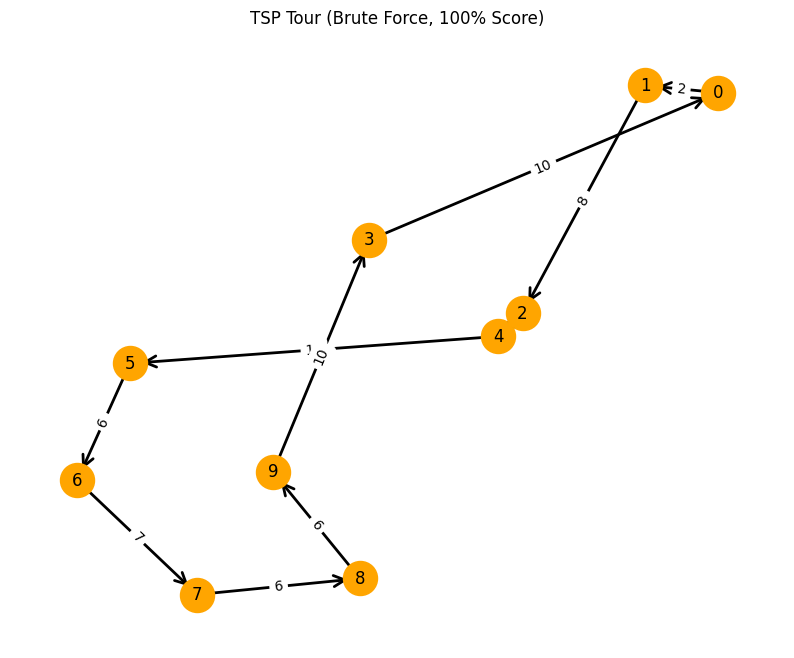

In [7]:
def plot_tsp_solution(tsp, tour, algorithm):
    G = nx.DiGraph()
    for i in range(tsp.n):
        for j in range(tsp.n):
            if i != j and tsp.matrix[i][j] >= 0:
                G.add_edge(i, j, weight=tsp.matrix[i][j])
    pos = nx.kamada_kawai_layout(G, weight='weight') # Use weights as distances to affect node placement
    path_edges = [(tour[i], tour[(i + 1) % tsp.n]) for i in range(tsp.n)]
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=600)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='black', arrows=True, arrowstyle='->',
                           arrowsize=20, width=2)
    edge_labels = {(u, v): f"{tsp.matrix[u][v]}" for u, v in path_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f"TSP Tour ({algorithm})")
    plt.axis('off')
    plt.show()
    
plot_tsp_solution(tsp, optimal_tour, "Brute Force, 100% Score")

It is now type to different ways to find the best (or a near-perfect) solution without using the expensive brute force algorithm.

# 2. Greedy Heuristics

We define a **greedy optimization algorithm** as an heuristic methods that does not take into account the memory of the past searches. It will take a decision only based on the immediate best candidate at each iteration of the process. An example is the nearest neiborhood heuristic (NN) that will pick the closest node at each iteration, starting from a random node:

In [8]:
def nn_solution(tsp):
    random.seed(RANDOM_SEED)
    start = random.randrange(tsp.n)
    current = start
    unvisited = set(range(tsp.n))
    unvisited.remove(start)
    tour = [start]
    for _ in tqdm(range(tsp.n-1), desc="Running NN"):
        neighbors = tsp.get_neighbors(current)
        valid_neighbors = [(j, d) for j, d in neighbors if j in unvisited]
        if not valid_neighbors:
            break
        next_node, _ = min(valid_neighbors, key=lambda x: x[1])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return tour

In [9]:
%%time
tour = nn_solution(tsp)

Running NN:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 12.2 ms, sys: 3.75 ms, total: 16 ms
Wall time: 14 ms


NN Tour: [9, 7, 8, 5, 6, 3, 2, 4, 1, 0]
NN Distance: 151
NN Score (%): 43.71


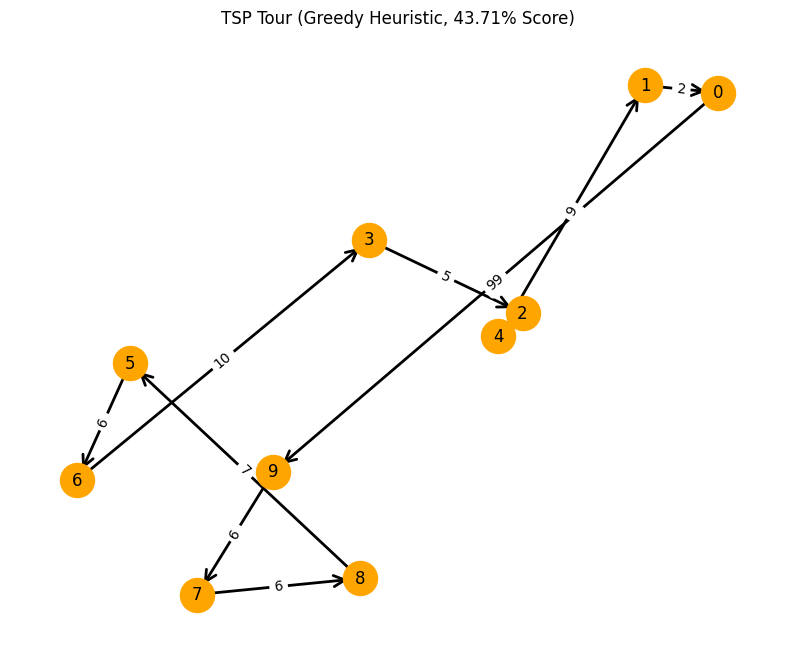

In [10]:
result = tsp.evaluate_solution(tour)
print("NN Tour:", tour)
print("NN Distance:", result[0])
print("NN Score (%):", round(result[1], 2))
plot_tsp_solution(tsp, tour, f"Greedy Heuristic, {round(result[1], 2)}% Score")

In this example (10 nodes), NN was 360 times fatser than the brute force search (this difference rises exponentially with the number of nodes) but demonstrated a low performance (43.71%) despite the simplicity of this expamplary problem.

How can we keep this process fast while maintaining a good performance? By taking into accoun memory and other factors, as the Ant Colony System does.

# 3. The Ant System

The ACO algorithm is a powerful heuristic using **memory** to remember partial tours. Being at a city i, choose next city j **probabilistically** among feasible neighboring cities.

## 3.1 Swarm system

ACO is a **swarm system**. It uses a series of $m$ "ants" (agents) that will explore different regions of the search space and communicate information to each other until a solution is found.

## 3.2 Probabilistic choice of next node

 The probabilistic choice depends on:
  - Pheromone trails $\tau_{ij}$ (representing memory);
  - Heuristic information $\eta_{ij} = \frac{1}{d_{ij}}$ (the "best local solution" chosen by a greedy algorithm);
A random proportional rule is used to compute the probability of moving from city j to city i:

$$
p_{ij}^k(t) = 
\frac{
  \left[ \tau_{ij}(t) \right]^\alpha \cdot \left[ \eta_{ij} \right]^\beta
}{
  \sum\limits_{l \in N_i^k} \left[ \tau_{il}(t) \right]^\alpha \cdot \left[ \eta_{il} \right]^\beta
}
\quad \text{if } j \in N_i^k
$$

where $N_i^k$ is the neighborhood of the node i.

## 3.3 Memory system (pheromones)

The **pheromone system** is compmlex on its own. It contains mechanisms for pheronome evaporation (forgetting mechanism) ruled by the parameter $\rho$, and pheromone deposition (positive reinforcement of good solutions).

Let $m$ be the number of ants and $L_k$ the tour length of ant $k$, here is an example of pheromones update rule:

$$
\tau_{ij}(t) = (1 - \rho) \cdot \tau_{ij}(t - 1) + \sum_{k=1}^{m} \Delta \tau_{ij}^k
$$

$$
\Delta \tau_{ij}^k = \frac{1}{L_k}, \quad \text{if edge } (i, j) \text{ is used by ant } k \text{ on its tour}
$$

## 3.4 Implementation and testing of ACO

The class below implements the optimization algorithm described above:


In [11]:
class ACO:
    def __init__(self, tsp, alpha=1.0, beta=2.0, rho=0.5, initial_pheromone=1.0, n_ants=10, max_iterations=100, seed=RANDOM_SEED):
        self.tsp = tsp
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.initial_pheromone = initial_pheromone
        self.n_ants = n_ants
        self.max_iterations = max_iterations
        self.n = tsp.n
        random.seed(seed)
        np.random.seed(seed)

        # Initialize pheromone matrix
        self.pheromone = np.full((self.n, self.n), self.initial_pheromone)
        np.fill_diagonal(self.pheromone, 0)

        # Initialize heuristic information (1 / distance)
        # For edges with distance < 0, we treat them as disconnected (heuristic = 0).
        self.heuristic = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.tsp.matrix[i][j] >= 0:
                    self.heuristic[i][j] = 1.0 / self.tsp.matrix[i][j]

        # Probability matrix
        self.prob_matrix = np.zeros((self.n, self.n))

        # Global best
        self.best_cost = float('inf')
        self.best_tour = None

    def run(self):
        for _ in tqdm(range(self.max_iterations), desc="Running ACO"):
            tours = []
            costs = []

            # Build solutions (one per ant)
            for _ant in range(self.n_ants):
                tour = self.construct_solution()
                cost = self.tsp.evaluate_solution(tour)
                if isinstance(cost, tuple):
                    cost = cost[0]  # ignore score if the TSP has an optimal reference
                tours.append(tour)
                costs.append(cost)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_tour = tour

            # Evaporate pheromones
            self.pheromone *= (1 - self.rho)

            # Deposit pheromones
            for tour, cost in zip(tours, costs):
                if cost == float('inf'):
                    continue
                deposit = 1.0 / cost
                for i in range(len(tour) - 1):
                    a, b = tour[i], tour[i + 1]
                    self.pheromone[a][b] += deposit
                    self.pheromone[b][a] += deposit
                # Complete the cycle
                a, b = tour[-1], tour[0]
                self.pheromone[a][b] += deposit
                self.pheromone[b][a] += deposit

            # Recompute probability matrix
            self.update_prob_matrix()

        return self.best_tour, self.best_cost

    def update_prob_matrix(self):
        # prob_matrix[i][j] = (tau_ij^alpha) * (eta_ij^beta)
        # but if distance < 0, we keep probability at 0
        numerator = (self.pheromone ** self.alpha) * (self.heuristic ** self.beta)
        self.prob_matrix = numerator

    def construct_solution(self):
        # Random start
        start = random.randrange(self.n)
        tour = [start]
        visited = set([start])
        for _step in range(self.n - 1):
            current = tour[-1]
            next_city = self.choose_next_city(current, visited)
            tour.append(next_city)
            visited.add(next_city)
        return tour

    def choose_next_city(self, current, visited):
        row = self.prob_matrix[current]
        # Filter out visited or invalid edges
        probs = []
        nodes = []
        for j in range(self.n):
            if j not in visited and self.tsp.matrix[current][j] >= 0:
                probs.append(row[j])
                nodes.append(j)

        if not probs:
            # If no unvisited neighbor is available, choose randomly among valid ones
            valid_neighbors = [j for j in range(self.n)
                               if j not in visited and self.tsp.matrix[current][j] >= 0]
            if not valid_neighbors:
                return random.randrange(self.n)  # fallback (won't be a great path)
            return random.choice(valid_neighbors)

        total = sum(probs)
        pick = random.random() * total
        cumsum = 0.0
        for node, p in zip(nodes, probs):
            cumsum += p
            if cumsum >= pick:
                return node
        return nodes[-1]

Now, we will test the ACO on our previous TSP example with our default ACO parameters:

In [12]:
default_aco_params = {
    "alpha": 1.0,               # Influence of pheromone trail strength (higher = more exploitation of learned paths)
    "beta": 2.0,                # Influence of heuristic information (1/distance); higher = more greedy
    "rho": 0.5,                 # Pheromone evaporation rate (higher = faster evaporation, encourages exploration)
    "initial_pheromone": 1.0,   # Initial amount of pheromone on all edges
    "n_ants": 10,               # Number of ants (solutions) constructed per iteration
    "max_iterations": 100       # Maximum number of algorithm iterations
}
aco = ACO(tsp, **default_aco_params)

In [13]:
%%time
best_tour, best_cost = aco.run()

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 88.5 ms, sys: 2.07 ms, total: 90.6 ms
Wall time: 86.7 ms


ACO Best Tour: [3, 0, 1, 2, 4, 5, 6, 7, 8, 9]
ACO Best Cost: 66
ACO Score (%): 100.0


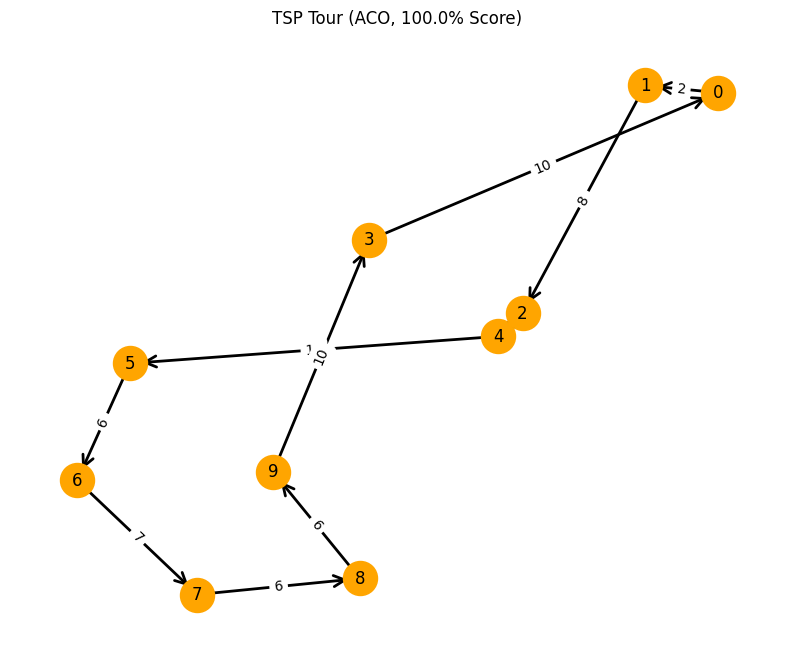

In [14]:
score = round(optimal_cost/best_cost*100, 2)
print("ACO Best Tour:", best_tour)
print("ACO Best Cost:", best_cost)
print("ACO Score (%):", score)
plot_tsp_solution(tsp, best_tour, f"ACO, {score}% Score")

This result is very satisfying: we obtained the optimal solution with an algorithm which is only 7 times slower than the greedy one! Now let's test ACO on a much more complicated example:

In [15]:
def generate_symmetric_matrix(n, low=1, high=99):
    upper_triangle = np.random.randint(low, high + 1, size=(n, n))
    matrix = np.triu(upper_triangle, k=1)
    symmetric_matrix = matrix + matrix.T
    return symmetric_matrix

n = 100
matrix = generate_symmetric_matrix(n)
big_tsp = TSP(matrix)

print("Time estimated for a TSP brute force search on this matrix:", factorial(n)/factorial(10)*9, "seconds.")

Time estimated for a TSP brute force search on this matrix: 2.314638279859726e+152 seconds.


In [16]:
%%time
tour = nn_solution(big_tsp)

Running NN:   0%|          | 0/99 [00:00<?, ?it/s]

CPU times: user 28.4 ms, sys: 2.05 ms, total: 30.5 ms
Wall time: 31.4 ms


NN Tour: [79, 83, 44, 50, 5, 72, 77, 65, 8, 14, 53, 4, 12, 21, 45, 55, 3, 74, 48, 7, 24, 42, 22, 49, 38, 16, 34, 30, 63, 1, 62, 40, 57, 32, 26, 88, 36, 58, 23, 99, 97, 67, 51, 28, 86, 0, 33, 35, 41, 43, 82, 52, 98, 18, 37, 93, 66, 61, 70, 17, 68, 89, 76, 25, 46, 19, 20, 64, 39, 84, 10, 9, 71, 54, 94, 29, 47, 91, 59, 95, 92, 11, 60, 13, 87, 27, 80, 73, 85, 56, 78, 2, 75, 90, 81, 69, 6, 15, 96, 31]
NN Distance: 491


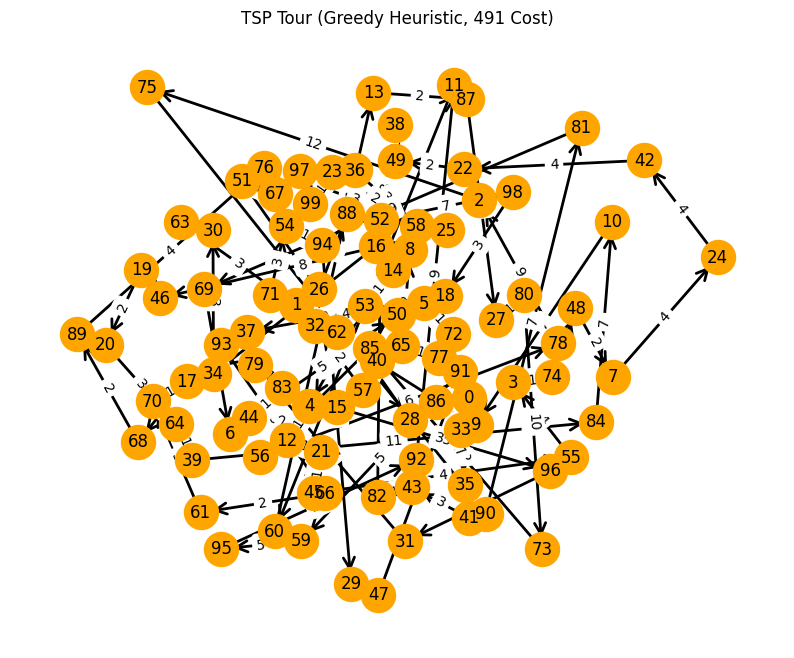

In [17]:
result = big_tsp.evaluate_solution(tour)
print("NN Tour:", tour)
print("NN Distance:", result[0])
plot_tsp_solution(big_tsp, tour, f"Greedy Heuristic, {result[0]} Cost")

In [18]:
aco = ACO(big_tsp, **default_aco_params)

In [19]:
%%time
best_tour, best_cost = aco.run()

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 4.44 s, sys: 31 ms, total: 4.47 s
Wall time: 4.43 s


ACO Best Tour: [7, 48, 74, 3, 90, 66, 61, 20, 19, 46, 37, 93, 79, 83, 44, 38, 49, 2, 65, 77, 72, 5, 94, 54, 67, 51, 28, 92, 64, 39, 12, 4, 53, 50, 18, 98, 58, 14, 8, 52, 88, 36, 71, 62, 1, 69, 17, 70, 95, 59, 29, 31, 40, 57, 32, 26, 56, 85, 21, 45, 55, 78, 13, 87, 22, 84, 42, 24, 75, 47, 91, 86, 9, 10, 81, 23, 99, 97, 11, 63, 30, 34, 16, 76, 25, 68, 89, 96, 33, 0, 27, 80, 73, 82, 43, 15, 6, 60, 35, 41]
ACO Best Cost: 382


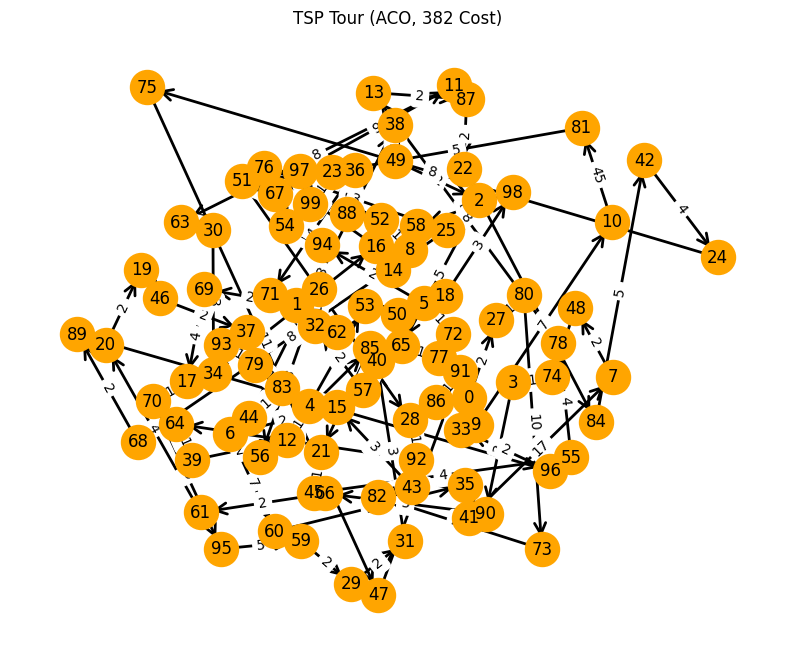

In [20]:
print("ACO Best Tour:", best_tour)
print("ACO Best Cost:", best_cost)
plot_tsp_solution(big_tsp, best_tour, f"ACO, {best_cost} Cost")

This time, the ACO algorithm took several seconds, but its performance is much better than the greedy one.

# 4. Parameter Tuning

So far, we solely used the `default_aco_params` configuration. However, the quality of the solution can be improved with a more accurate choice of parameters for our specific problem (the TSP). Here is a simple example where we make the process 10 times faster, but impacting negatively the quality of the solution:

In [21]:
faster_aco_params = default_aco_params.copy()
faster_aco_params["max_iterations"] = 10

aco = ACO(big_tsp, **faster_aco_params)
best_tour, best_cost = aco.run()

print("Faster ACO Best Cost:", best_cost)

Running ACO:   0%|          | 0/10 [00:00<?, ?it/s]

Faster ACO Best Cost: 560


Here, ACO performance is close to the NN one. What if we rose the number of ants instead?

In [22]:
more_ants_aco_params = default_aco_params.copy()
more_ants_aco_params["n_ants"] = 100

aco = ACO(big_tsp, **more_ants_aco_params)
best_tour, best_cost = aco.run()

print("More Ants ACO Best Cost:", best_cost)

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

More Ants ACO Best Cost: 314


Performance is improved but the execution is considerably slower. Now, what about the parameters $\alpha$, $\beta$ and $\rho$? Testing them one by one would take a very long time. Thankfully, the `optuna` library can do it for us, using intelligent optimization algorithm to rapidly converge towards an efficient parameter configuration:

In [23]:
def ACO_parameter_tuning(tsp, n_trials=10, plot_graph=False):
    def objective(trial):
        params = {
            "alpha": trial.suggest_float("alpha/beta", 0.5, 10.0, log=True),
            "beta": 1,
            "rho": trial.suggest_float("rho", 0.1, 0.9),
            "initial_pheromone": trial.suggest_float("initial_pheromone", 0.1, 5.0),
            "n_ants": 10,
            "max_iterations": 100
        }

        aco = ACO(tsp, **params)
        best_tour, best_cost = aco.run()

        gc.collect() # avoids some RAM problems

        return best_cost

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    if plot_graph:
        importances = get_param_importances(study)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(importances.values()), y=list(importances.keys()))
        plt.title("Hyperparameter Importance")
        plt.xlabel("Importance")
        plt.ylabel("Hyperparameter")
        plt.tight_layout()
        plt.show()

    return study

In [24]:
study = ACO_parameter_tuning(big_tsp, 50)

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Best parameters after optimization: {'alpha/beta': 2.669788541369762, 'rho': 0.10244885995277166, 'initial_pheromone': 1.1893099892152805}
Best cost after optimization: 291.0


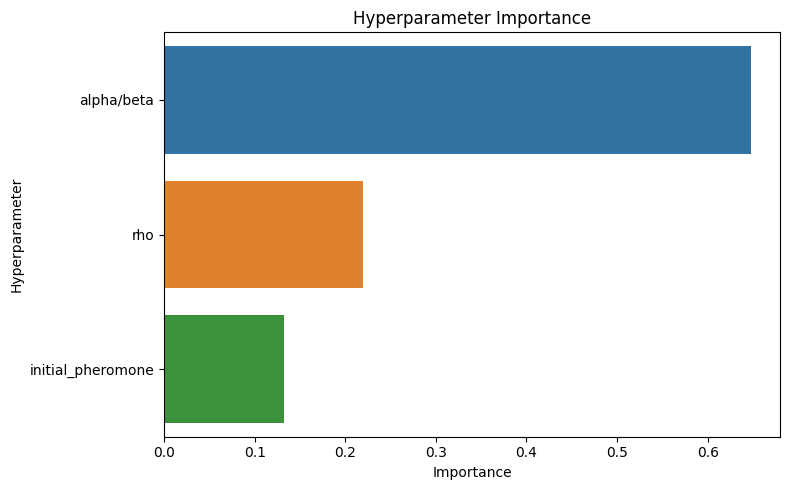

In [25]:
print("Best parameters after optimization:", study.best_params)
print("Best cost after optimization:", study.best_value)

importances = get_param_importances(study)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(importances.values()), y=list(importances.keys()))
plt.title("Hyperparameter Importance")
plt.xlabel("Importance")
plt.ylabel("Hyperparameter")
plt.tight_layout()
plt.show()

This new configuration is a major improvement towards the default one, and did not rise the execution time! Better results can be expected for a larger number of `optuna` iterations. It is also interesting to observe that the quality of the best solution is not as sentsitive on the $\alpha/\beta$ ratio (influence of the memory against the greedy approach) that we might think: the evaporation rate or the initial pheromone value brings more diversity in the results of this `optuna` experiment.

It is not reasonably possible to compute the optimal solution for this problem, so it is very difficult to estimate "how good" this solution is. In order to do that, we will select problems for which a near-perfect solution is already known.

# 5. Benchmark Tests on the TSPLIB Dataset

The [TSPLIB](https://github.com/mastqe/tsplib) dataset provides a series of benchmark TSP problems along with their best near-optimal solutions found so far (it is not possible to assert that those are *the* opimal solution but it provides a useful upper bound to the problem). Special thanks to [Ziya](https://www.kaggle.com/ziya07) for uploading and preprocessing this dataset on Kaggle to make it easily compatible with `pandas`.

In [26]:
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS, "ziya07/traveling-salesman-problem-tsplib-dataset", "tsp_dataset.csv"
)

solutions_file_path = INPUT_DIR + 'tsplib/solutions'

df.head()

,instance_id,num_cities,city_coordinates,distance_matrix,best_route,total_distance
0,0,55,"[[1.5151906140833948, 19.177278494739536], [73...","[[0.0, 79.11154474360372, 101.756895828171, 80...",Route_0,2966.177188
1,1,37,"[[9.171788789539214, 5.737255811751718], [3.89...","[[0.0, 72.09203311327578, 61.47916503925607, 6...",Route_1,2170.736411
2,2,98,"[[1.2441510811264989, 23.27370647332514], [5.4...","[[0.0, 63.81087388426054, 69.21850448864502, 9...",Route_2,4999.939027
3,3,83,"[[51.16142038162509, 53.89731654368458], [67.5...","[[0.0, 37.28444606337496, 30.029805963176333, ...",Route_3,4365.673956
4,4,92,"[[13.136651237291607, 61.89786629917011], [44....","[[0.0, 35.153916594166496, 50.454966560026094,...",Route_4,5339.213132


There are 2783 TSP problems in this dataset.


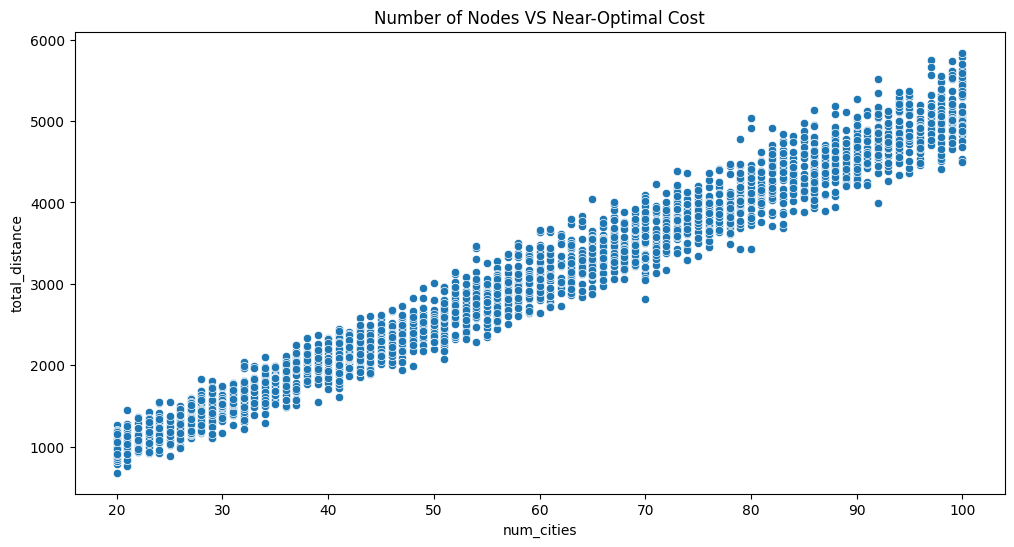

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Number of Nodes VS Near-Optimal Cost")
sns.scatterplot(x=df.num_cities, y=df.total_distance)
print("There are", df.shape[0], "TSP problems in this dataset.")

We need to ensure that the matrices contained in `df` have the same format as `M` and `matrix`:

In [28]:
df_small = df[:10]
df_small['matrix_dims'] = [(len(eval(df.distance_matrix.loc[k])), len(eval(df.distance_matrix.loc[k])[0])) for k in range(df_small.shape[0])]
df_small[['num_cities', 'matrix_dims']].head(10)

,num_cities,matrix_dims
0,55,"(55, 55)"
1,37,"(37, 37)"
2,98,"(98, 98)"
3,83,"(83, 83)"
4,92,"(92, 92)"
5,42,"(42, 42)"
6,43,"(43, 43)"
7,65,"(65, 65)"
8,73,"(73, 73)"
9,44,"(44, 44)"


In [29]:
del df
gc.collect() # Free some RAM space

3585

Now, let's test ACO on the first benchmark problems and compare its performance with the optimized version and the NN version:

In [30]:
df_small = df_small.assign(**{"NN cost": None, "ACO cost": None, "ACO opt cost": None})

for problem in range(df_small.shape[0]):
    M = eval(df_small.distance_matrix.loc[problem])
    tsp = TSP(M)
    tsp.optimal_cost = float(df_small.total_distance.loc[problem])

    print("Evaluating NN (greedy approach)...")
    tour = nn_solution(tsp)
    result = tsp.evaluate_solution(tour)
    df_small['NN cost'].loc[problem] = result[0]

    print("Evaluating ACO (default parameters)...")
    aco = ACO(tsp, **default_aco_params)
    best_tour, best_cost = aco.run()
    df_small['ACO cost'].loc[problem] = best_cost

    print("Evaluating ACO (optuna optimization)...")
    study = ACO_parameter_tuning(tsp, 10)
    best_cost = study.best_value
    df_small['ACO opt cost'].loc[problem] = best_cost

    gc.collect()

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/97 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/91 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating NN (greedy approach)...


Running NN:   0%|          | 0/43 [00:00<?, ?it/s]

Evaluating ACO (default parameters)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating ACO (optuna optimization)...


Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

Running ACO:   0%|          | 0/100 [00:00<?, ?it/s]

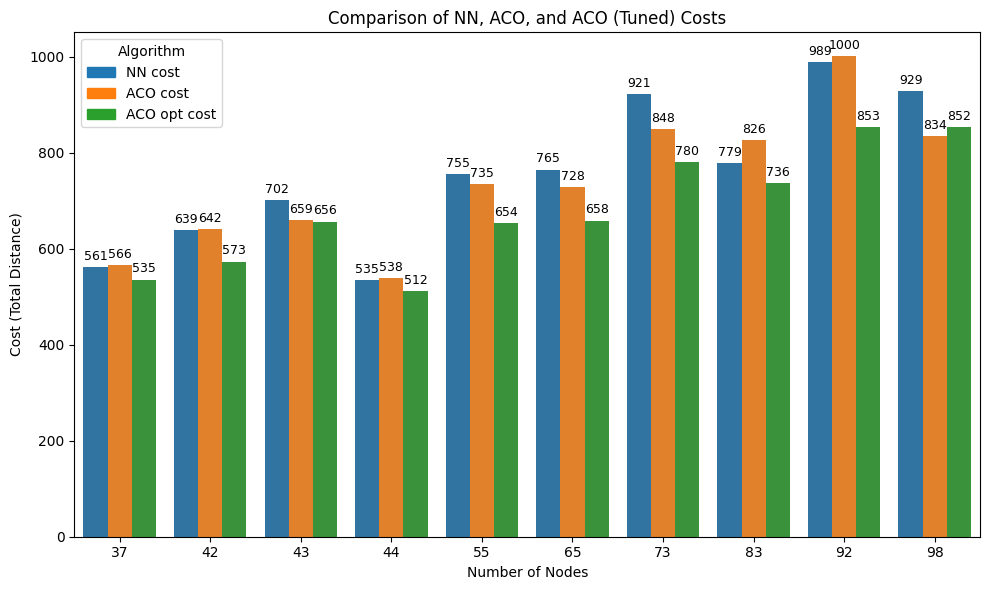

In [31]:
df_small["NN cost"] = df_small["NN cost"].astype(float)
df_small["ACO cost"] = df_small["ACO cost"].astype(float)
df_small["ACO opt cost"] = df_small["ACO opt cost"].astype(float)
df_small["num_cities"] = df_small["num_cities"].astype(int)

# Melt the DataFrame to long format
df_melted = df_small.melt(id_vars="num_cities",
                          value_vars=["NN cost", "ACO cost", "ACO opt cost"],
                          var_name="Algorithm",
                          value_name="Score")

df_melted = df_melted.sort_values("num_cities")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="num_cities", y="Score", hue="Algorithm")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

color_map = {
    "NN cost": "#1f77b4",        # blue
    "ACO cost": "#ff7f0e",       # orange
    "ACO opt cost": "#2ca02c"    # green
}
custom_order = ["NN cost", "ACO cost", "ACO opt cost"]
custom_handles = [mpatches.Patch(color=color_map[label], label=label) for label in custom_order]
ax.legend(handles=custom_handles, title="Algorithm")

plt.title("Comparison of NN, ACO, and ACO (Tuned) Costs")
plt.xlabel("Number of Nodes")
plt.ylabel("Cost (Total Distance)")
plt.tight_layout()
plt.show()

<p style="padding: 20px;
          background-color: green;
          font-family: computermodern;
          color: white;
          font-size: 200%;
          text-align: center;
          border-radius: 40px 20px;
          ">Thank you!</p>